In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 
#from pcygni_9 import PcygniCalculator
from pcygni_9 import PcygniCalculator

import pickle
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time
import corner

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

### Importing Data and Binning

In [2]:
OB = 'OB1'
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3300) & (x[:,0] < 22500)

wl, flux, error = x[:,0], x[:,1], x[:,2]#x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
error = error * 2.26

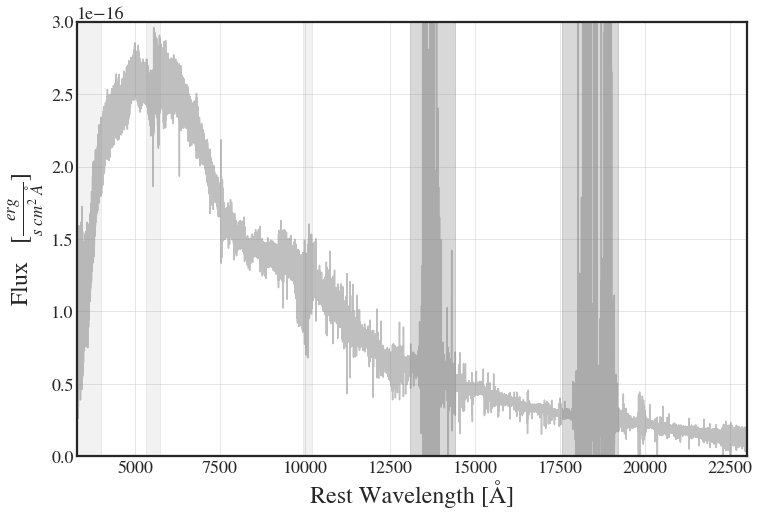

In [3]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

#plt.plot(wl_50, flux_50, label='X-shooter spectra', color='red', alpha=0.5)

#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [4]:
pickle_in = open("./data/OB1/OB1_fit_ratio_vel_perfect_100x2500.pkl","rb")

#pickle_in = open("./Data/OB2/OB2_fit_ratio_vel_090_notperfect_42x100.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p.add('ratio_vel', value=1.0001, min=0.5, max=2)
#p.add('theta_inc', value=21, min=0, max=90)

In [5]:
#np.sum( (flux[(wl>6000) & (wl<10000)]-residual(p, wl[(wl>6000) & (wl<10000)]*1e-10))**2/error[(wl>6000) & (wl<10000)]**2 )/len(flux[(wl>6000) & (wl<10000)])

In [6]:
nbins=20
n_skip = int(np.shape(wl)[0])%nbins

wl_bin   = np.median(np.reshape(wl[n_skip:], (int(len(flux[n_skip:])/nbins), nbins )), axis=1)
flux_bin = np.average(np.reshape(flux[n_skip:], (int(len(flux[n_skip:])/nbins), nbins )), axis=1)#, 
                  #weights = 1/(np.reshape(error[n_skip:], (int(len(error[n_skip:])/nbins), nbins )))**2 )

#e_flux_bin = np.mean(np.reshape(error[4:], (int(len(error[4:])/10), 10 )), axis=1)
e_flux_bin = np.std(np.reshape(flux[n_skip:],(int(len(flux[n_skip:])/nbins), nbins )), axis=1)*2#/np.sqrt(nbins-1)

len(flux_bin)

2965

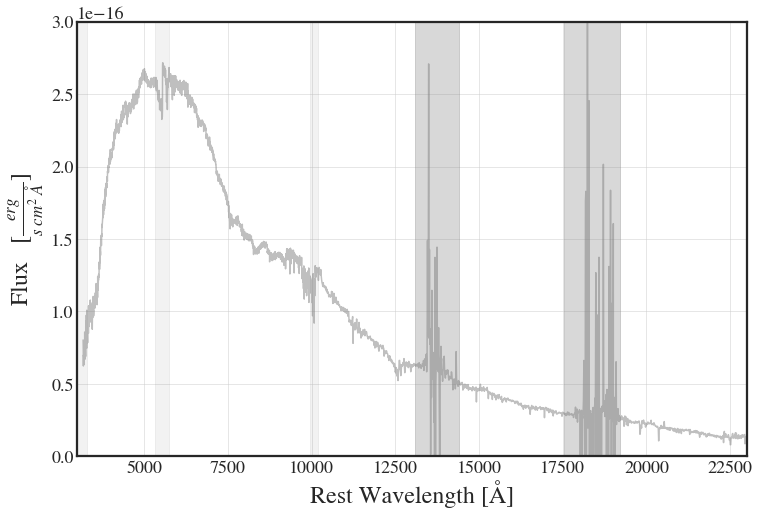

In [7]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl_bin, flux_bin, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3000, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 3300], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

In [8]:
exc_reg = (~((wl_bin > 13100) & (wl_bin < 14400))) & (~((wl_bin > 17550) & (wl_bin < 19200))) & \
          (~((wl_bin > 5330) & (wl_bin < 5740))) & (~((wl_bin > 9840) & (wl_bin < 10300))) & \
          (wl_bin > 3300) & (wl_bin < 22500)

wl, flux, error = wl_bin[exc_reg], flux_bin[exc_reg], e_flux_bin[exc_reg]

In [9]:
#np.mean( (flux[(wl>6000) & (wl<10000)]-residual(p, wl[(wl>6000) & (wl<10000)]*1e-10))**2/error[(wl>6000) & (wl<10000)]**2 )#/len(flux[(wl>6000) & (wl<10000)])

In [10]:
#np.median( (flux[(wl>6000) & (wl<10000)]-residual(p, wl[(wl>6000) & (wl<10000)]*1e-10))**2/error[(wl>6000) & (wl<10000)]**2 )#/len(flux[(wl>6000) & (wl<10000)])

In [11]:
#np.std( (flux[(wl>6000) & (wl<10000)]-residual(p, wl[(wl>6000) & (wl<10000)]*1e-10) )/flux[(wl>6000) & (wl<10000)] )

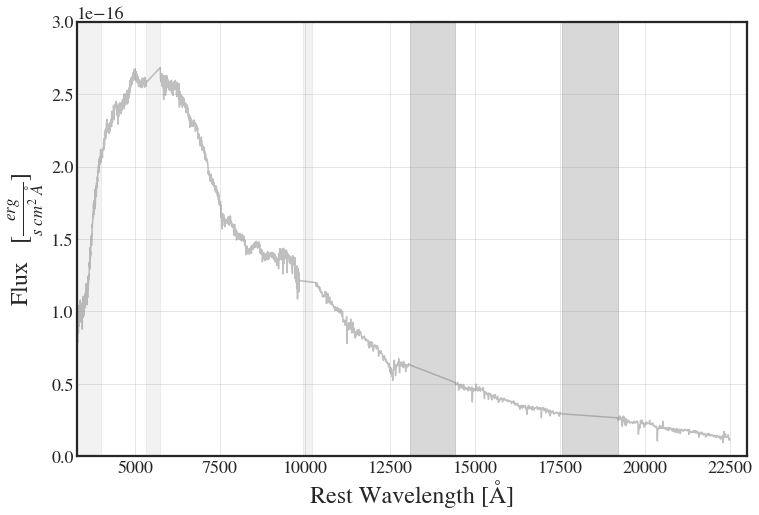

In [12]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)
#plt.plot(wl, flux+error, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

### Fitting Code

In [13]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, ratio_vel = 1, t0 = 120960, theta_inc=21): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA, ratio_vel = ratio_vel, theta_inc=theta_inc)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32, 
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, ratio_vel = 1, theta_inc=21): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    #pcyg_profn = p_cygni_line_corr(wav, v_out, v_phot, tau   , 10456, vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    #pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    #pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    
    #pcyg_profn = p_cygni_line_corr(wav, v_out, v_phot, tau   , 10456, vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel, theta_inc=theta_inc)
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5

    #correction = pcyg_profn #pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    ratio_vel = v["ratio_vel"]
    theta_inc = v['theta_inc']
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, ratio_vel=ratio_vel, 
                           theta_inc=theta_inc)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

### Fit

Parameters([('T', <Parameter 'T', value=5435.716791746477 +/- 4.42, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3404076532489784e-29 +/- 4.83e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27768223610679355 +/- 0.00191, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.34633402047380324 +/- 0.00114, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=35.43711858345176 +/- 11.7, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.07449505547902187 +/- 0.00639, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.0005456328535526188 +/- 2.25e-05, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.26169986240919846 +/- 0.0123, bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.43011965591121504 +/- 0.0365, bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.55e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2.03e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=1.234466933355993e-07 +/- 8.44e-09, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.1077466515307957e-07 +/- 4.78e-08, bounds=[1e-08:3e-07]>), ('ratio_vel', <Parameter 'ratio_vel', value=1.01, bounds=[0.5:2]>), ('theta_inc', <Parameter 'theta_inc', value=22, bounds=[19:25]>)])

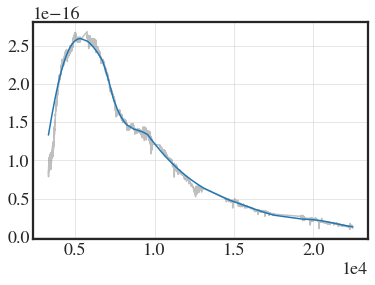

In [14]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_2.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('ratio_vel', value=1.01, min=0.5, max=2)
p.add('theta_inc', value=22, min=19, max=25)
#p['occult'].value = 1
#p['ve'].value = 1
#p['tau'].value = 100
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

y_fit = residual(p, wl*1e-10)
plt.plot(wl, y_fit)
p

In [15]:
p['T'].vary=True; p['N'].vary = True; 
p['amp1'].vary=False; p['amp2'].vary=False;
p['cen1'].vary=False; p['cen2'].vary = False; 
p['sig1'].vary=False; p['sig2'].vary = False; 
mini = lmfit.Minimizer(lnprob, p) 

In [16]:
start = time.time()
nwalkers = 20 #v = p.valuesdict()
res9 = mini.emcee(nwalkers=nwalkers, burn=0, steps=500, thin=1, params=p, seed=12345, workers = 1)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )#wqeaaaaaaas

#with open("./Data/OB1/OB1_fit_ratio_vel_perfect_20x1200_inflated.pkl", 'wb') as outfile:
#    pickle.dump(res9, outfile) 

100%|██████████| 500/500 [5:44:37<00:00, 41.36s/it]  


The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [51.04001694 49.83406392 41.40250459 39.18508596 47.3808217  45.23346509
 52.90224834 40.54180968 42.47077838]
Time elapsed [hours]: 5.756579271356264


In [22]:
#with open("./Data/OB1/OB1_fit_ratio_vel_1027.pkl", 'wb') as outfile:
#    pickle.dump(res9, outfile) 

1.0278930394373669 1.0068363969532257 1.0548614309789215


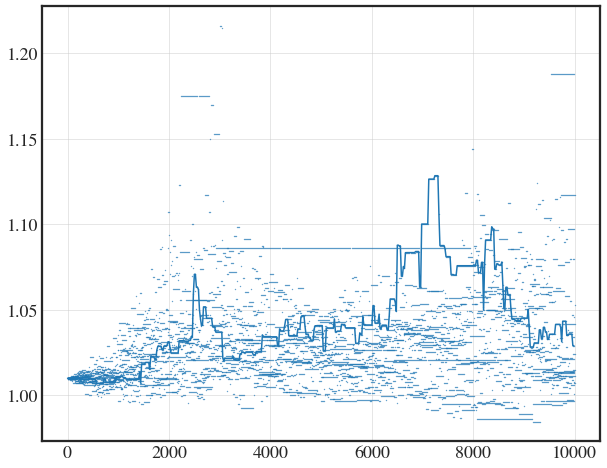

In [21]:
flat = res9.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=.1, alpha=1 ) 
plt.plot( np.arange(len(flat['theta_inc']))[::nwalkers], flat['ratio_vel'][::nwalkers] ) 
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][8000:]), np.percentile(flat['ratio_vel'][8000:], 16), np.percentile(flat['ratio_vel'][1000:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

1.0178938877700143 1.0004868988173223 1.0419390294771507


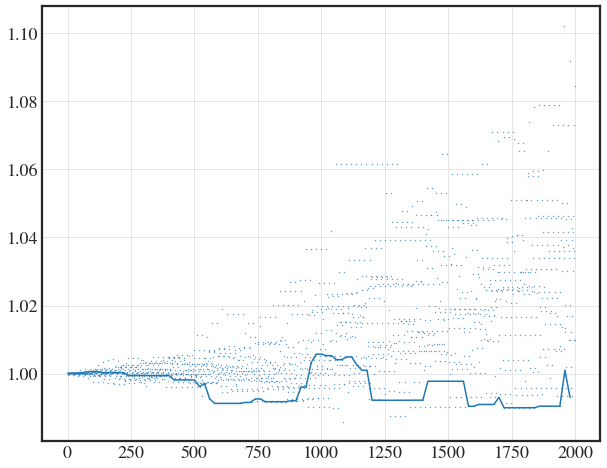

In [66]:
flat = res9.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=.1, alpha=1 ) 
plt.plot( np.arange(len(flat['theta_inc']))[::nwalkers], flat['ratio_vel'][::nwalkers] ) 
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][1000:]), np.percentile(flat['ratio_vel'][1000:], 16), np.percentile(flat['ratio_vel'][1000:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

In [16]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb")

#pickle_in = open("./Data/OB2/OB2_fit_ratio_vel_090_notperfect_42x100.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['ve'].max = 1
p['T'].vary=False; p['N'].vary = False; 
p['amp1'].vary=False; p['amp2'].vary=False;
p['cen1'].vary=False; p['cen2'].vary = False; 
p['sig1'].vary=False; p['sig2'].vary = False; 

#p['tau'].vary=False; p['ve'].vary = False; 
#p['vphot'].vary=False; p['vmax'].vary = False; 
#p['occult'].vary=False; #p['sig2'].vary = False; 

#p['tau'].value = 1.62

#p['ratio_vel'].min = 0.5; p['ratio_vel'].max = 2

p

Parameters([('T', <Parameter 'T', value=5440.8967947121055 (fixed), bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3338150746859284e-29 (fixed), bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27793590677592556 +/- 0.000611, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.3435875538574039 +/- 0.000707, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=19.888946177308384 +/- 4.76, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.011108657158602665 +/- 0.039, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.29438175177851106 (fixed), bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.478174226138591 (fixed), bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5201852353110815e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9228052277798637e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.596019384649572e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.757049301539864e-07 (fixed), bounds=[1e-08:3e-07]>)])

In [18]:
#pickle_in = open("./data/OB1/OB1_fit_ratio_vel_perfect_100x2500.pkl","rb")
#emcee_res = pickle.load(pickle_in)
#p = emcee_res.params

#p['T'].vary=True; p['N'].vary = True; 
#p['amp1'].vary=True; p['amp2'].vary=True;
#p['cen1'].vary=True; p['cen2'].vary = True; 
#p['sig1'].vary=True; p['sig2'].vary = True; 

In [18]:
pickle_in = open("./data/OB1/OB1_fit_ratio_vel_perfect_100x2500.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p['T'].vary=True; p['N'].vary = True; 

mini = lmfit.Minimizer(lnprob, p) 

In [20]:
start = time.time()
nwalkers = 20 #v = p.valuesdict()
res9 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=12345, workers = 1)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )#wqeaaaaaaas

#with open("./Data/OB1/OB1_fit_ratio_vel_perfect_20x1200_inflated.pkl", 'wb') as outfile:
#    pickle.dump(res9, outfile) 

100%|██████████| 2000/2000 [28:04:46<00:00, 50.54s/it]     


The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [131.76656818 137.92931507 226.40593048 161.06386628 193.40063829
 217.87266944 197.52750967 250.39859773 234.57451278]
Time elapsed [hours]: 28.09976924174362


In [31]:
#with open("./Data/OB1/Wrong_Spec_Rel.pkl", 'wb') as outfile:
#    pickle.dump(res9, outfile) 

(1.0800484489665823, 1.060969961593528)

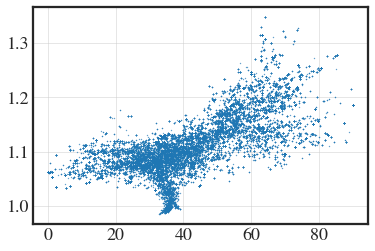

In [30]:
plt.scatter(flat['theta_inc'], flat['ratio_vel'], s=0.1)
np.median(flat['ratio_vel'][flat['theta_inc']<28]), np.percentile(flat['ratio_vel'][flat['theta_inc']<28], 15.9)

41.095212921193756 28.075985724838286


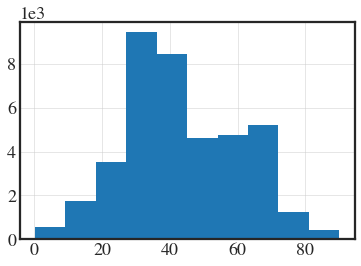

In [24]:
plt.hist(flat['theta_inc'])
print(np.median(flat['theta_inc']), np.percentile(flat['theta_inc'],15.9))

1.1019536084367565 1.0605796793803972 1.1740653576662385


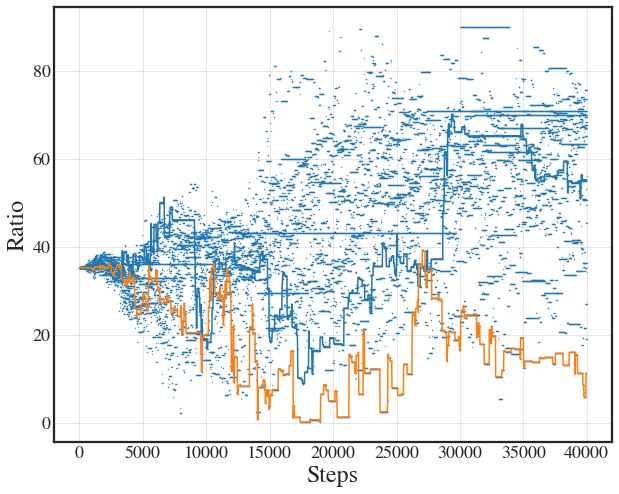

In [21]:
flat = res9.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=.1, alpha=1 ) 
plt.plot( np.arange(len(flat['theta_inc']))[::nwalkers], flat['theta_inc'][::nwalkers] ) 
plt.plot( np.arange(len(flat['theta_inc']))[1::nwalkers], flat['theta_inc'][1::nwalkers]) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][0:]), np.percentile(flat['ratio_vel'][0:], 16), np.percentile(flat['ratio_vel'][0:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

In [60]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 20 #v = p.valuesdict()
res8 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=12345, workers = 1)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )#wqeaaaaaaas

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 2000/2000 [113:50:39<00:00, 204.92s/it]   


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [165.39132014 161.01237212 200.55808699 198.1573524  202.10502656
 176.42179571 153.7377239 ]
Time elapsed [hours]: 113.92590270453029


In [61]:
#with open("./Data/OB1/OB1_fit_ratio_vel_perfect_100x2500.pkl", 'wb') as outfile:
#    pickle.dump(res8, outfile) 

In [37]:
res8.params

UnboundLocalError: local variable 'spercent' referenced before assignment

Parameters([('T', <Parameter 'T', value=5440.8967947121055 (fixed), bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3338150746859284e-29 (fixed), bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27764842559436664 +/- 0.00482, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.34333285750252623 +/- 0.00286, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=19.902432463059686 +/- 6.94, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.08669762800257862 +/- 0.00939, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.09699451111289156 +/- 0.107, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.29438175177851106 (fixed), bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.478174226138591 (fixed), bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5201852353110815e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.92

In [51]:
pickle_in = open("./Data/OB1/OB1_fit_ratio_vel_perfect_100x2500.pkl","rb")
res8 = pickle.load(pickle_in)

res8.acceptance_fraction
flat = res8.flatchain
theta_inc = flat['theta_inc']
print(np.median(flat['ratio_vel'][(theta_inc>19) & (theta_inc<25)]), 
      np.percentile(flat['ratio_vel'][(theta_inc>19) & (theta_inc<25)], 16), 
      np.percentile(flat['ratio_vel'][(theta_inc>19) & (theta_inc<25)], 84))

np.median(flat['ratio_vel'][(theta_inc>19) & (theta_inc<25)])-np.percentile(flat['ratio_vel'][(theta_inc>19) & (theta_inc<25)], 16)

0.9973291448304455 0.9799658138638209 1.0118353111717215


0.01736333096662468

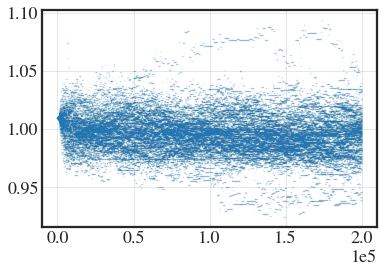

In [49]:
plt.scatter(np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=0.1, alpha=0.1)

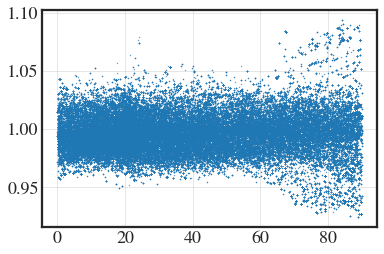

In [45]:
plt.scatter(flat['theta_inc'], flat['ratio_vel'], s=0.1)

In [62]:
res8.acceptance_fraction, np.mean(res8.acceptance_fraction), np.std(res8.acceptance_fraction)/np.sqrt(len(res8.acceptance_fraction))

(array([0.2185, 0.101 , 0.1905, 0.1665, 0.191 , 0.192 , 0.2115, 0.198 ,
        0.2035, 0.186 , 0.151 , 0.199 , 0.154 , 0.2095, 0.2105, 0.208 ,
        0.2085, 0.202 , 0.165 , 0.1405, 0.226 , 0.1685, 0.1125, 0.155 ,
        0.2085, 0.207 , 0.1515, 0.1835, 0.1925, 0.148 , 0.194 , 0.185 ,
        0.1995, 0.204 , 0.206 , 0.217 , 0.1805, 0.243 , 0.2175, 0.214 ,
        0.2285, 0.188 , 0.1895, 0.2275, 0.2405, 0.1965, 0.1855, 0.1815,
        0.1925, 0.219 , 0.2125, 0.2095, 0.2145, 0.1955, 0.166 , 0.098 ,
        0.223 , 0.2175, 0.2005, 0.149 , 0.1805, 0.2015, 0.1545, 0.159 ,
        0.209 , 0.2045, 0.212 , 0.148 , 0.216 , 0.202 , 0.154 , 0.216 ,
        0.2285, 0.195 , 0.207 , 0.214 , 0.2235, 0.2115, 0.213 , 0.1915,
        0.151 , 0.2025, 0.1895, 0.174 , 0.1735, 0.2075, 0.2135, 0.2115,
        0.168 , 0.213 , 0.2285, 0.203 , 0.1565, 0.168 , 0.216 , 0.2   ,
        0.191 , 0.174 , 0.1975, 0.159 ]),
 0.191935,
 0.0028052241889018428)

In [20]:
flat = res8.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][0:]), np.percentile(flat['ratio_vel'][0:], 16), np.percentile(flat['ratio_vel'][0:], 84))
plt.xlim(0,200000) #plt.xlim(0, 42*200)

NameError: name 'res8' is not defined

0.9961443220943175 0.9801196882661566 1.0127943538236917


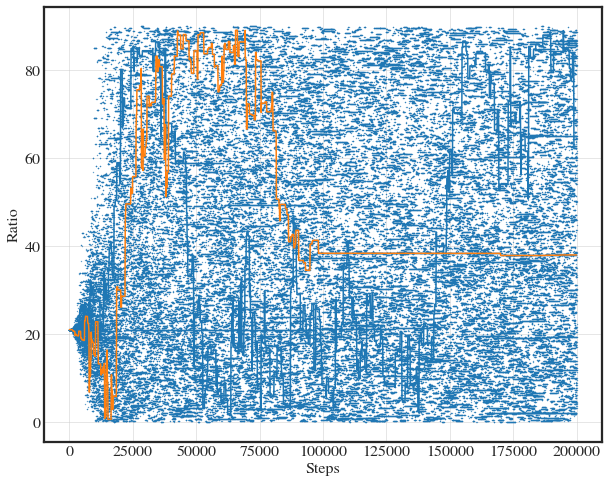

In [81]:
flat = res8.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=.1, alpha=1 ) 
plt.plot( np.arange(len(flat['theta_inc']))[::nwalkers], flat['theta_inc'][::nwalkers] ) 
plt.plot( np.arange(len(flat['theta_inc']))[1::nwalkers], flat['theta_inc'][1::nwalkers]) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][0:]), np.percentile(flat['ratio_vel'][0:], 16), np.percentile(flat['ratio_vel'][0:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

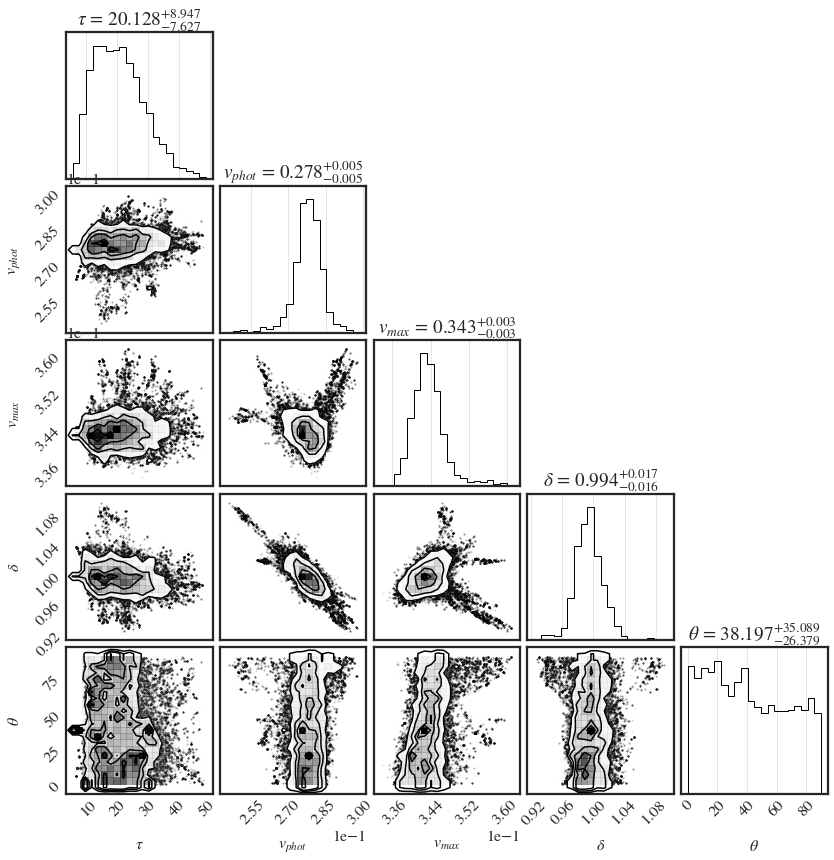

In [72]:
reset_plt(16,16)

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)

steady = 80000
corner.corner( np.array([flat['tau'][steady:], flat['vphot'][steady:], flat['vmax'][steady:], 
                         flat['ratio_vel'][steady:], flat['theta_inc'][steady:]]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

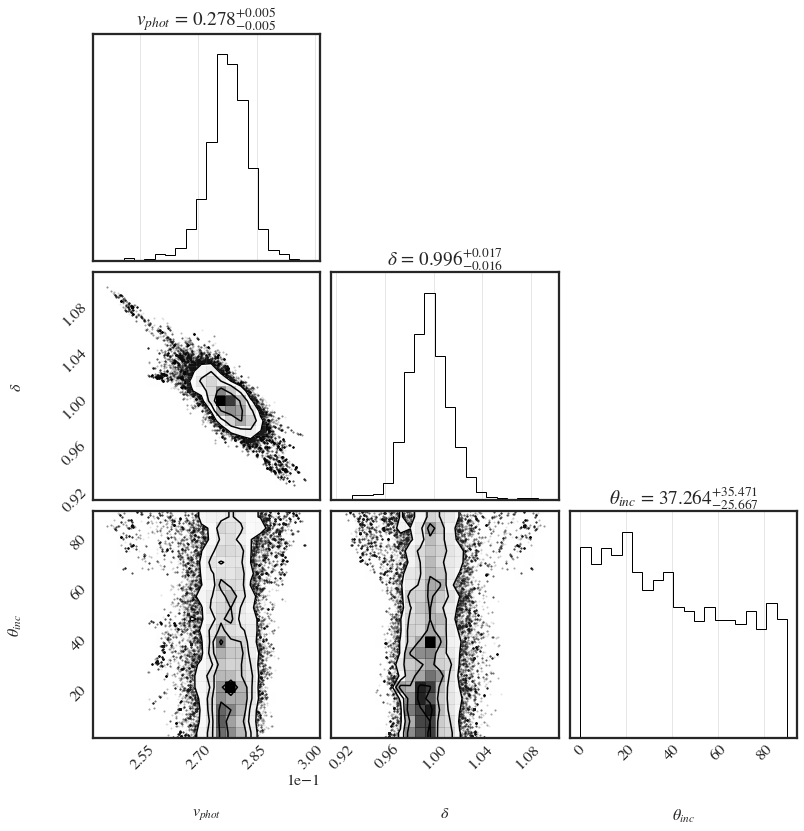

In [103]:
reset_plt(16,16)

fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3)

steady = 10000
corner.corner( np.array([flat['vphot'][steady:], 
                         flat['ratio_vel'][steady:], flat['theta_inc'][steady:]]).T, 
            labels=[r'$v_{phot}$', r'$\delta$', r'$\theta_{inc}$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

ax[2][0].set_ylim(0,90), ax[2][1].set_ylim(0,90)

#plt.savefig('Pictures/Angle_cov_epoch_1_0iter.png', dpi=300)

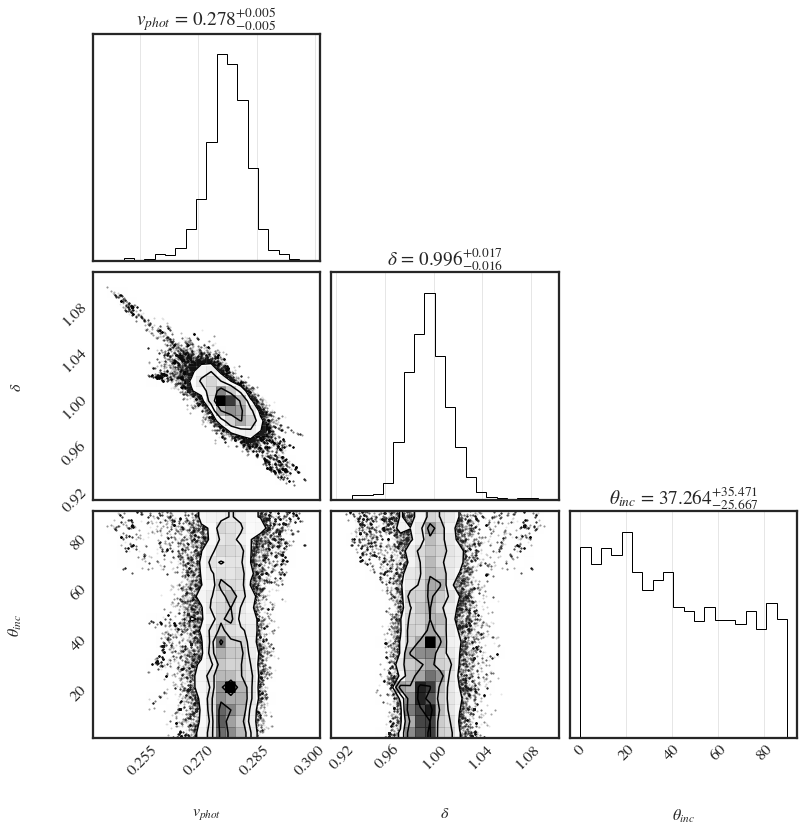

In [105]:
reset_plt(16,16)

fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3)

steady = 10000
corner.corner( np.array([flat['vphot'][steady:], 
                         flat['ratio_vel'][steady:], flat['theta_inc'][steady:]]).T, 
            labels=[r'$v_{phot}$', r'$\delta$', r'$\theta_{inc}$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

ax[2][0].set_ylim(0,90), ax[2][1].set_ylim(0,90)
ax[2][0].ticklabel_format(axis='x', style='plain')

#plt.savefig('Pictures/Angle_cov_epoch_1_0iter.png', dpi=300)

In [108]:
np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'], 15.9), np.percentile(flat['ratio_vel'], 100-15.9)

(0.9961443220943175, 0.9800545990002372, 1.0128948166852296)

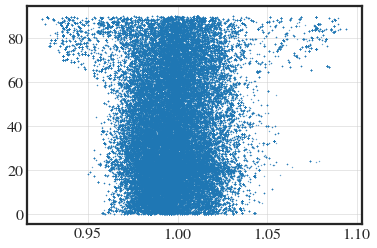

In [68]:
plt.scatter(flat['ratio_vel'], flat['theta_inc'],s=0.1)

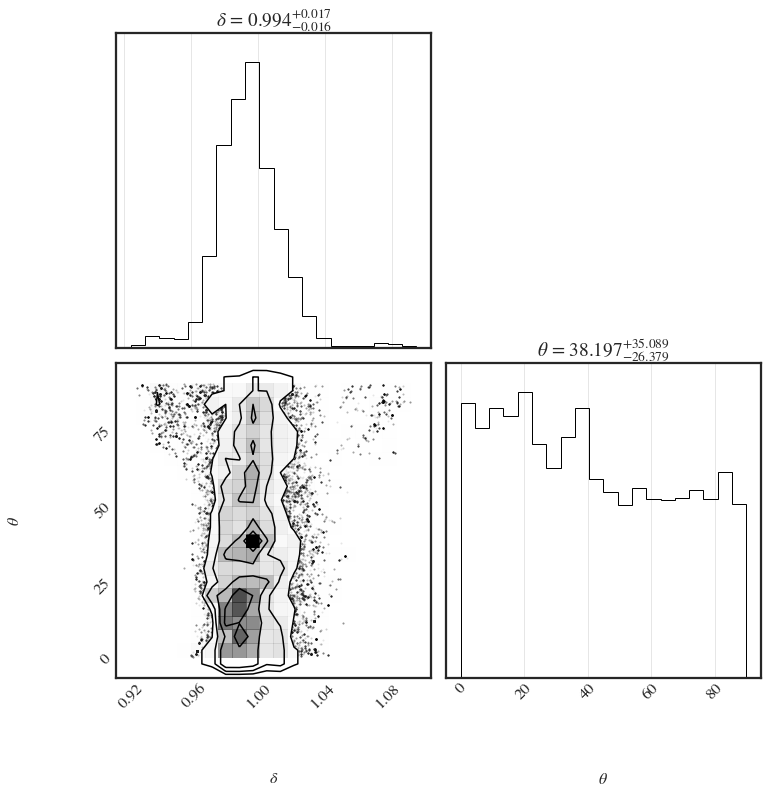

In [74]:
reset_plt(16,16)

fig,ax = plt.subplots(figsize=(12,12),nrows=2,ncols=2)

steady = 80000
corner.corner( np.array([flat['ratio_vel'][steady:], flat['theta_inc'][steady:]]).T, 
            labels=[r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

In [55]:
#with open("./Data/OB1/OB1_fit_ratio_vel_perfect_25x1000.pkl", 'wb') as outfile:
#    pickle.dump(res7, outfile) 

In [46]:
res7.acceptance_fraction, np.mean(res7.acceptance_fraction), np.std(res7.acceptance_fraction)/np.sqrt(len(res7.acceptance_fraction))

(array([0.227, 0.233, 0.192, 0.254, 0.236, 0.255, 0.256, 0.266, 0.269,
        0.265, 0.268, 0.257, 0.292, 0.247, 0.255, 0.221, 0.211, 0.213,
        0.226, 0.229, 0.178, 0.213, 0.283, 0.23 , 0.243]),
 0.24076,
 0.005392225514571882)

0.9914213455143109 0.9779193632495404 1.0076093340743417


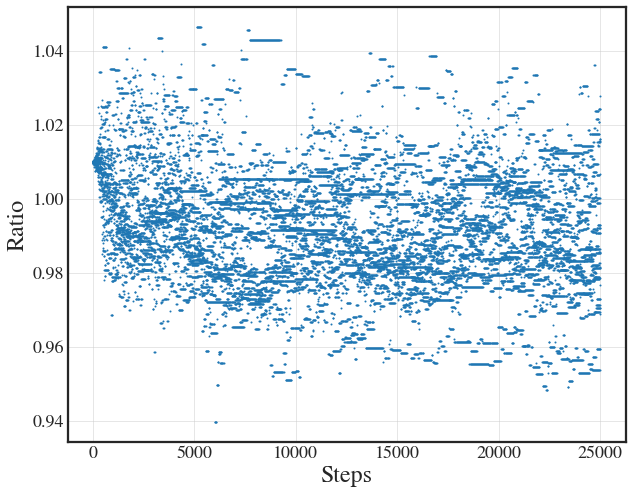

In [47]:
flat = res7.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][0:]), np.percentile(flat['ratio_vel'][0:], 16), np.percentile(flat['ratio_vel'][0:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

0.9914213455143109 0.9779193632495404 1.0076093340743417


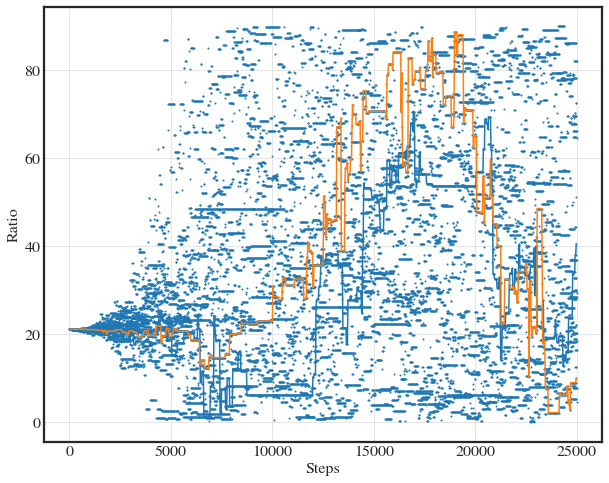

In [58]:
flat = res7.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=1, alpha=1 ) 
plt.plot( np.arange(len(flat['theta_inc']))[::nwalkers], flat['theta_inc'][::nwalkers] ) 
plt.plot( np.arange(len(flat['theta_inc']))[1::nwalkers], flat['theta_inc'][1::nwalkers]) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][0:]), np.percentile(flat['ratio_vel'][0:], 16), np.percentile(flat['ratio_vel'][0:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

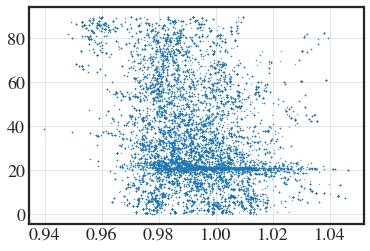

In [51]:
plt.scatter(flat['ratio_vel'], flat['theta_inc'],s=0.1)

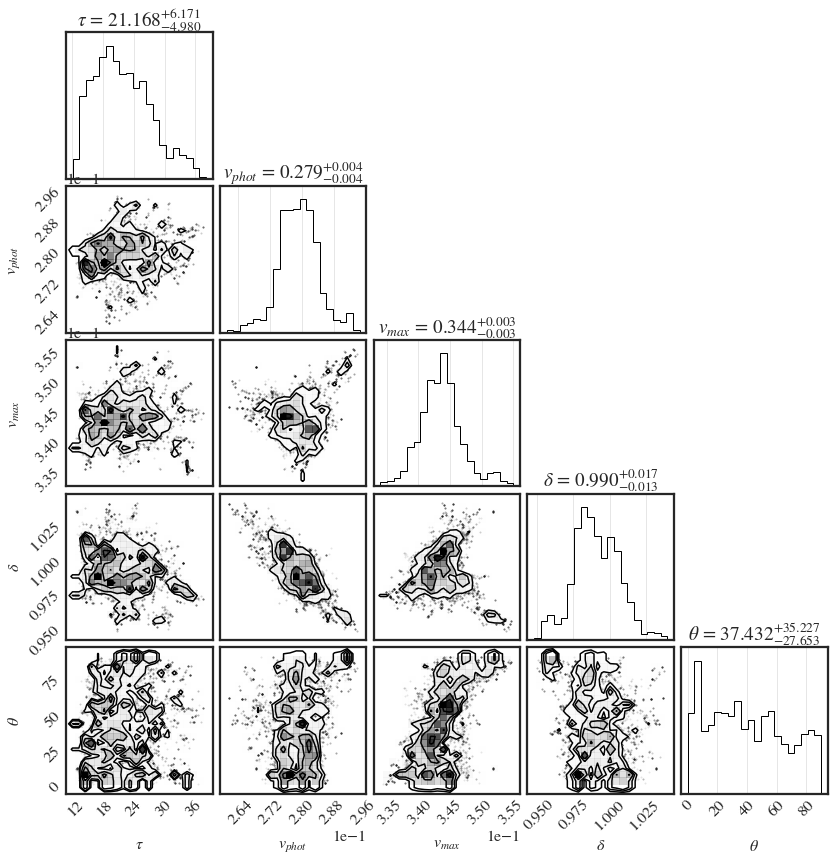

In [53]:
reset_plt(16,16)

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)

steady = 10000
corner.corner( np.array([flat['tau'][steady:], flat['vphot'][steady:], flat['vmax'][steady:], 
                         flat['ratio_vel'][steady:], flat['theta_inc'][steady:]]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

In [78]:
theta_inc = flat['theta_inc']
ratio_vel = flat['ratio_vel']

np.median( ratio_vel[(theta_inc>14) & (theta_inc<28)] ), np.percentile( ratio_vel[(theta_inc>14) & (theta_inc<28)], 15.9 ), np.percentile( ratio_vel[(theta_inc>14) & (theta_inc<28)], 100-15.9 )

(0.9954608546761523, 0.980169964064234, 1.0115523254747911)

In [79]:
np.median( ratio_vel ), np.percentile( ratio_vel, 15.9 ), np.percentile( ratio_vel, 100-15.9 )

(0.997175081447927, 0.9677924637074525, 1.0154105066591423)

In [80]:
np.median( ratio_vel ), np.percentile( ratio_vel, 15.9 ), np.percentile( ratio_vel, 100-15.9 )

(0.9961443220943175, 0.9800545990002372, 1.0128948166852296)

In [39]:
res6.acceptance_fraction, np.mean(res6.acceptance_fraction), np.std(res6.acceptance_fraction)/np.sqrt(len(res6.acceptance_fraction))

(array([0.43 , 0.385, 0.375, 0.35 , 0.36 , 0.345, 0.435, 0.37 , 0.345,
        0.35 , 0.35 , 0.35 , 0.38 , 0.445, 0.41 , 0.395, 0.34 , 0.32 ,
        0.385, 0.4  ]),
 0.376,
 0.007546522377890363)

1.00296846153064 0.9869071834345068 1.0122504036714557


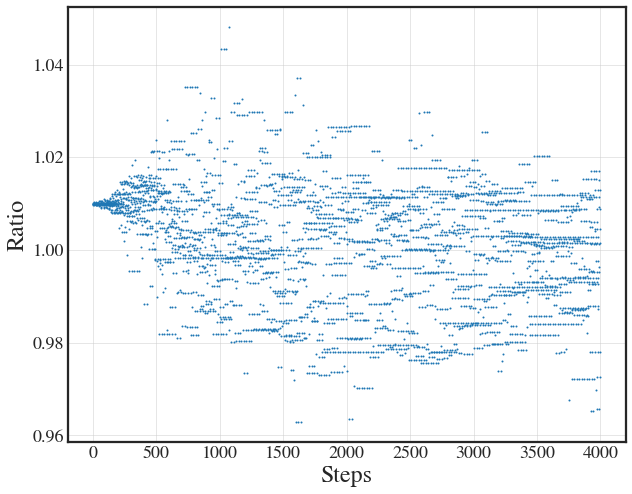

In [41]:
flat = res6.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][0:]), np.percentile(flat['ratio_vel'][0:], 16), np.percentile(flat['ratio_vel'][0:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

1.00296846153064 0.9869071834345068 1.0122504036714557


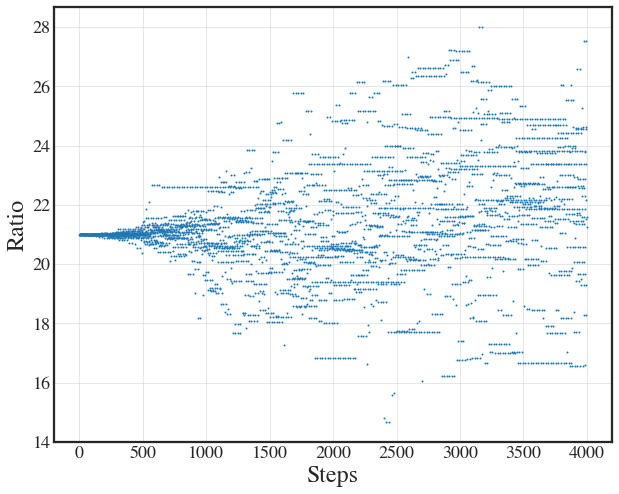

In [42]:
flat = res6.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][0:]), np.percentile(flat['ratio_vel'][0:], 16), np.percentile(flat['ratio_vel'][0:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

In [23]:
res5.acceptance_fraction, np.mean(res5.acceptance_fraction), np.std(res5.acceptance_fraction)/np.sqrt(len(res5.acceptance_fraction))

(array([0.265, 0.26 , 0.235, 0.255, 0.17 , 0.315, 0.18 , 0.235, 0.115,
        0.205, 0.18 , 0.165, 0.26 , 0.135, 0.18 , 0.12 , 0.115, 0.105,
        0.18 , 0.315, 0.275, 0.24 , 0.18 , 0.295, 0.26 , 0.275, 0.125,
        0.21 , 0.055, 0.27 , 0.34 , 0.27 , 0.33 , 0.22 , 0.24 , 0.145,
        0.3  , 0.17 , 0.13 , 0.12 , 0.33 , 0.2  , 0.095, 0.06 , 0.175,
        0.205, 0.245, 0.255, 0.23 , 0.345]),
 0.21160000000000004,
 0.010502799626766188)

0.9979307394908101 0.9882110389784985 1.0063638256049654


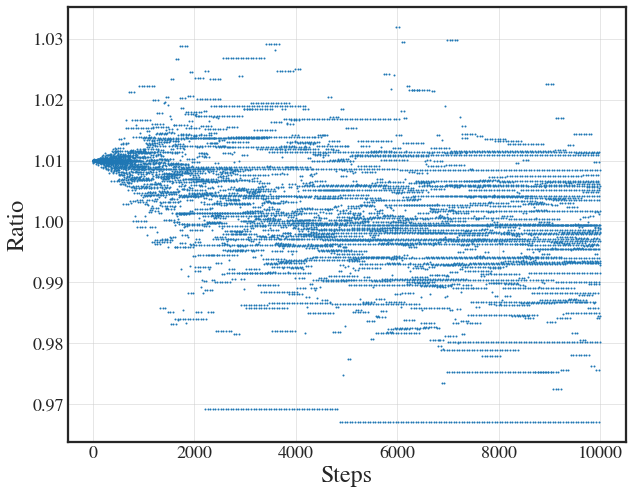

In [26]:
flat = res5.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel'][8000:]), np.percentile(flat['ratio_vel'][8000:], 16), np.percentile(flat['ratio_vel'][8000:], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

1.0017028280591846 0.9928190155256974 1.0104039656780504


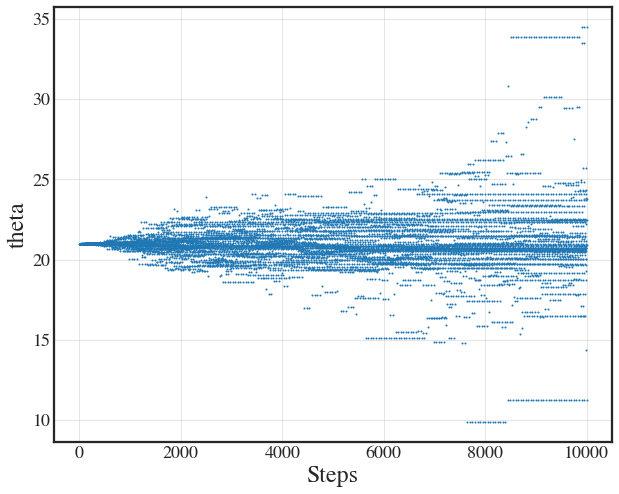

In [25]:
flat = res5.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=1, alpha=1 ) 
plt.ylabel('theta'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'], 16), np.percentile(flat['ratio_vel'], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

In [37]:
#with open("./Data/OB1/OB1_fit_ratio_vel_100_perfect_42x1000.pkl", 'wb') as outfile:
#    pickle.dump(res4, outfile) 

In [21]:
res4.acceptance_fraction, np.mean(res4.acceptance_fraction), np.std(res4.acceptance_fraction)/np.sqrt(len(res4.acceptance_fraction))

(array([0.32 , 0.33 , 0.2  , 0.17 , 0.105, 0.295, 0.235, 0.34 , 0.35 ,
        0.215, 0.11 , 0.09 , 0.285, 0.27 ]),
 0.23678571428571424,
 0.02338457946706145)

1.0043193329171398 0.992678120240343 1.0101917901782818


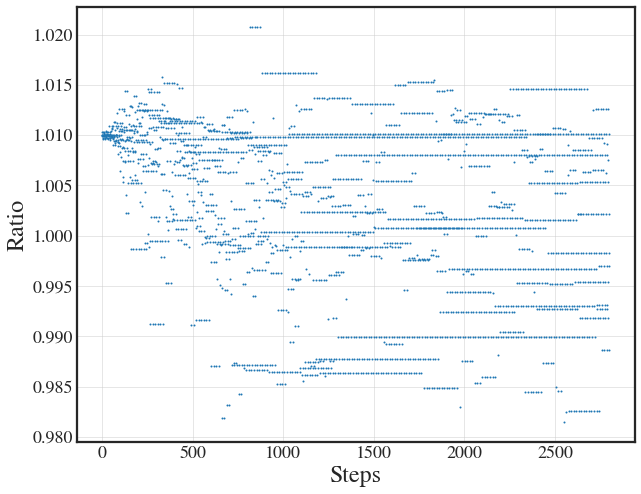

In [17]:
flat = res4.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'], 16), np.percentile(flat['ratio_vel'], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

1.0043193329171398 0.992678120240343 1.0101917901782818


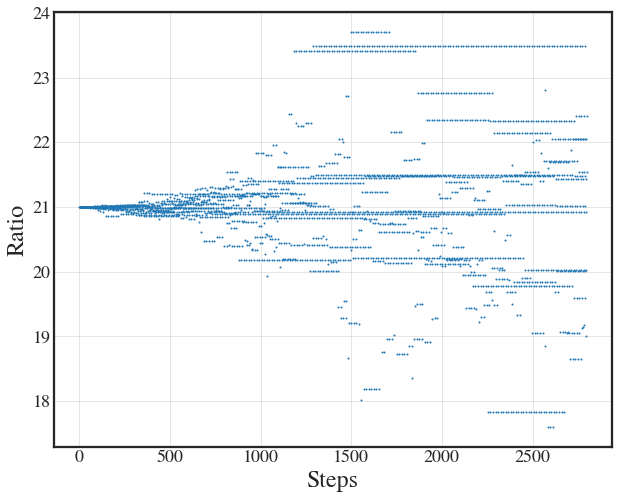

In [18]:
flat = res4.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'], 16), np.percentile(flat['ratio_vel'], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

In [38]:
res4.acceptance_fraction

array([0.049, 0.062, 0.056, 0.045, 0.08 , 0.039, 0.047, 0.072, 0.048,
       0.031, 0.04 , 0.054, 0.058, 0.066, 0.04 , 0.054, 0.039, 0.05 ,
       0.058, 0.06 , 0.055, 0.043, 0.057, 0.043, 0.044, 0.06 , 0.057,
       0.057, 0.041, 0.065, 0.055, 0.048, 0.059, 0.045, 0.048, 0.046,
       0.064, 0.079, 0.06 , 0.083, 0.039, 0.057])

1.0672151010407185 1.008142568793535 1.0843812111666784


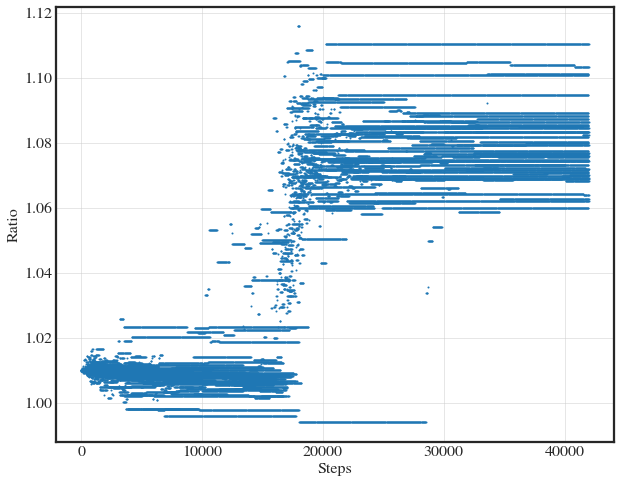

In [54]:
flat = res4.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'], 16), np.percentile(flat['ratio_vel'], 84))
#plt.xlim(0,20000) #plt.xlim(0, 42*200)

21.35915747647773 20.78664021077616 22.80782115425845


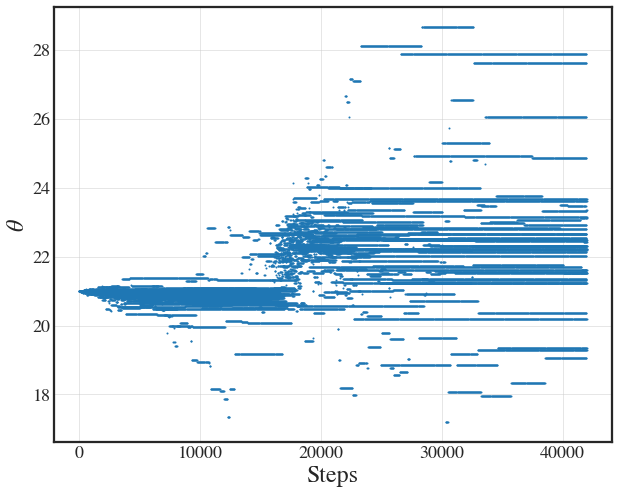

In [41]:
plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=1, alpha=1 ) 
plt.ylabel(r'$\theta$'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['theta_inc']), np.percentile(flat['theta_inc'], 16), np.percentile(flat['theta_inc'], 84))

In [43]:
res4.flatchain

vphot      vmax        tau        ve    occult  ratio_vel  theta_inc
0      0.277930  0.343604  19.887913  0.086399  0.011111   1.010141  21.000195
1      0.277944  0.343614  19.891425  0.086412  0.011107   1.010028  21.000481
2      0.277974  0.343618  19.884965  0.086400  0.011111   1.009956  20.998867
3      0.277949  0.343699  19.886915  0.086398  0.011109   1.010031  21.001100
4      0.277936  0.343634  19.887527  0.086396  0.011106   1.009812  20.998192
...         ...       ...        ...       ...       ...        ...        ...
41995  0.264657  0.347328  15.256997  0.086691  0.014360   1.075854  19.290632
41996  0.267678  0.349209  15.912620  0.087588  0.014419   1.083317  20.189318
41997  0.265888  0.348592  16.380867  0.085579  0.015260   1.074203  22.306966
41998  0.265858  0.346765  17.005825  0.085128  0.016561   1.072002  22.417919
41999  0.265689  0.346610  16.947377  0.084908  0.015206   1.068288  21.526946

[42000 rows x 7 columns]

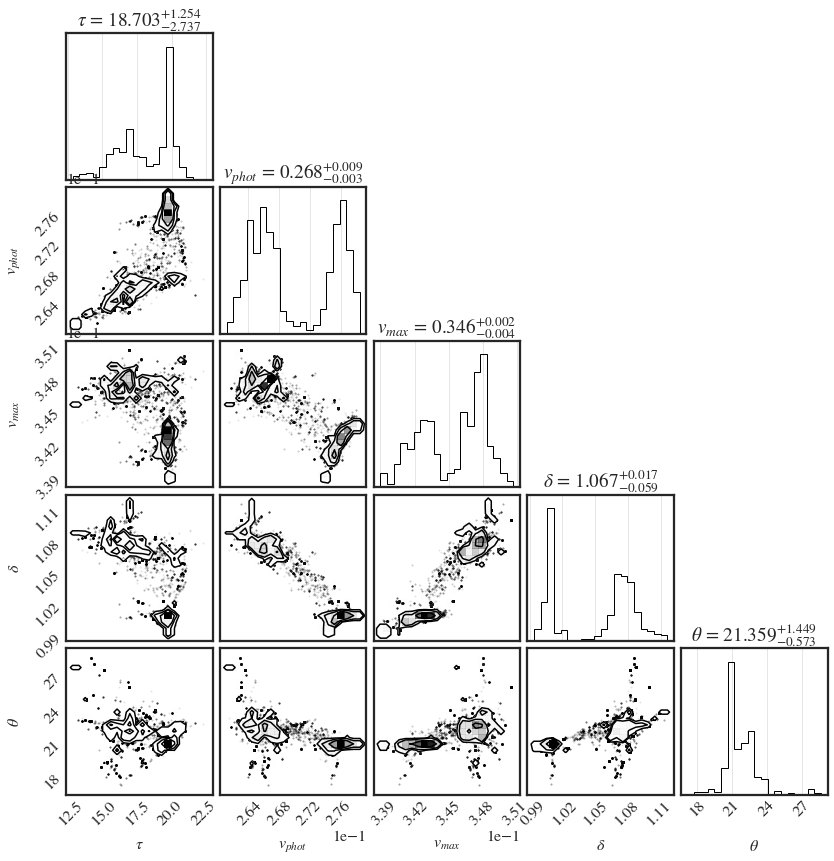

In [46]:
reset_plt(16,16)

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)

corner.corner( np.array([flat['tau'], flat['vphot'], flat['vmax'], flat['ratio_vel'], flat['theta_inc']]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

In [49]:
np.percentile(flat['ratio_vel'], 15.9), np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'], 100-15.9)

(1.0080819078880725, 1.0672151010407185, 1.0844436497880974)

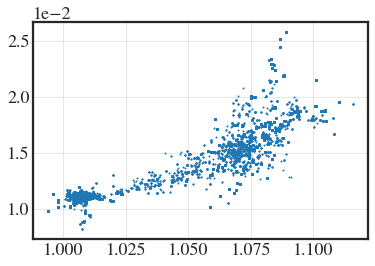

In [45]:
plt.scatter(flat['ratio_vel'], flat['occult'], s=1)

In [20]:
res5.acceptance_fraction

array([0.17 , 0.19 , 0.165, 0.125, 0.11 , 0.15 , 0.13 , 0.15 , 0.145,
       0.125, 0.06 , 0.115, 0.105, 0.155, 0.165, 0.1  , 0.125, 0.17 ,
       0.16 , 0.14 , 0.1  , 0.14 , 0.18 , 0.115, 0.16 , 0.135, 0.125,
       0.15 , 0.13 , 0.22 , 0.14 , 0.14 , 0.17 , 0.115, 0.19 , 0.17 ,
       0.145, 0.18 , 0.115, 0.105, 0.145, 0.13 ])

1.0498243548567887 1.0421327144262353 1.0530174276146136


(0.0, 20000.0)

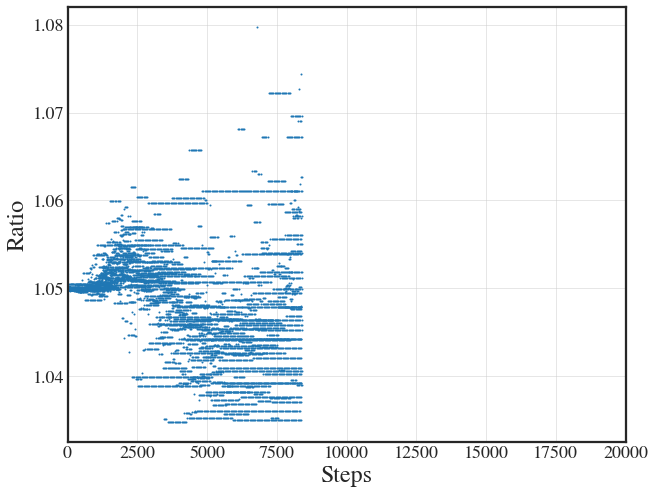

In [21]:
flat = res5.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['ratio_vel'], s=1, alpha=1 ) 
plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['ratio_vel']), np.percentile(flat['ratio_vel'], 16), np.percentile(flat['ratio_vel'], 84))
plt.xlim(0,20000)

20.99574817042438 20.356480755709146 21.090887119641664


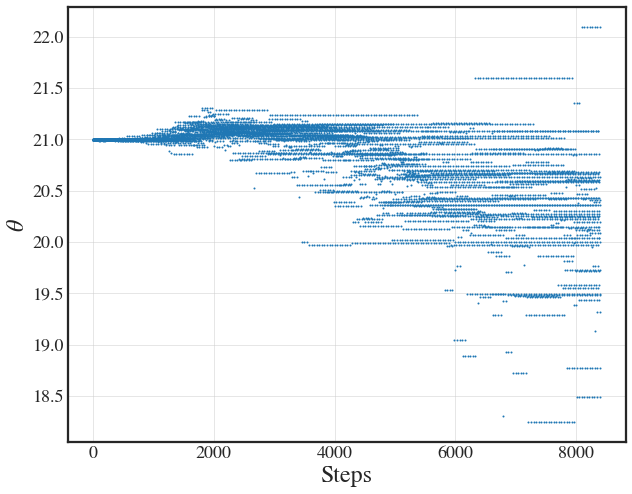

In [22]:
plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat['theta_inc'])), flat['theta_inc'], s=1, alpha=1 ) 
plt.ylabel(r'$\theta$'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')
print(np.median(flat['theta_inc']), np.percentile(flat['theta_inc'], 16), np.percentile(flat['theta_inc'], 84))

In [24]:
res5.flatchain

vphot      vmax        tau        ve    occult  ratio_vel  theta_inc
0     0.277937  0.343623  19.886857  0.086396  0.011111   1.050207  21.000062
1     0.277939  0.343597  19.890382  0.086405  0.011108   1.049964  20.997877
2     0.277952  0.343623  19.886717  0.086399  0.011110   1.049956  20.999064
3     0.277949  0.343699  19.886915  0.086398  0.011109   1.050032  21.001100
4     0.277936  0.343634  19.887527  0.086396  0.011106   1.049805  20.998192
...        ...       ...        ...       ...       ...        ...        ...
8395  0.268904  0.347537  20.615575  0.081737  0.009213   1.062716  19.313581
8396  0.274568  0.350094  19.748413  0.085554  0.010794   1.061033  20.365625
8397  0.270126  0.347544  19.610770  0.083200  0.010082   1.055088  20.086284
8398  0.266915  0.346647  18.998562  0.082212  0.010126   1.056115  19.724064
8399  0.274765  0.346026  20.020381  0.085519  0.010564   1.040574  20.630937

[8400 rows x 7 columns]

In [131]:
#with open("./Data/OB2/OB2_fit_ratio_vel_090_notperfect_42x100.pkl", 'wb') as outfile:
#    pickle.dump(res5, outfile) 

In [121]:
p

Parameters([('T', <Parameter 'T', value=3935.619453803755 (fixed), bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.752046990957482e-29 (fixed), bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24759563525437875 +/- 0.000606, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.27924953077917924 +/- 0.000543, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.7206571723678954 +/- 0.149, bounds=[0:10]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.780007595922463 +/- 0.171, bounds=[0:1]>), ('occult', <Parameter 'occult', value=1.4727446008300493 +/- 0.0539, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.731925498290273 (fixed), bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.7738771406419194 (fixed), bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.5189211092097167e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9002850656969605e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=6.647026591600895e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.2594738400456657e-07 (fixed), bounds=[1e-08:3e-07]>), ('ratio_vel', <Parameter 'ratio_vel', value=0.9, bounds=[0.5:2]>), ('theta_inc', <Parameter 'theta_inc', value=14, bounds=[0:90]>)])

In [97]:
res4.acceptance_fraction

array([0.364, 0.33 , 0.336, 0.344, 0.32 , 0.238, 0.29 , 0.322, 0.27 ,
       0.294, 0.304, 0.304, 0.348, 0.302, 0.35 , 0.342, 0.314, 0.302,
       0.294, 0.296, 0.314, 0.256, 0.288, 0.24 , 0.322, 0.334, 0.238,
       0.304, 0.284, 0.328, 0.246, 0.312, 0.358, 0.274, 0.242, 0.318,
       0.308, 0.252, 0.236, 0.348, 0.36 , 0.276])

1.01037205163148 0.030752486775160046
1.0004133833583695 0.9940526252289077 1.016837600436107


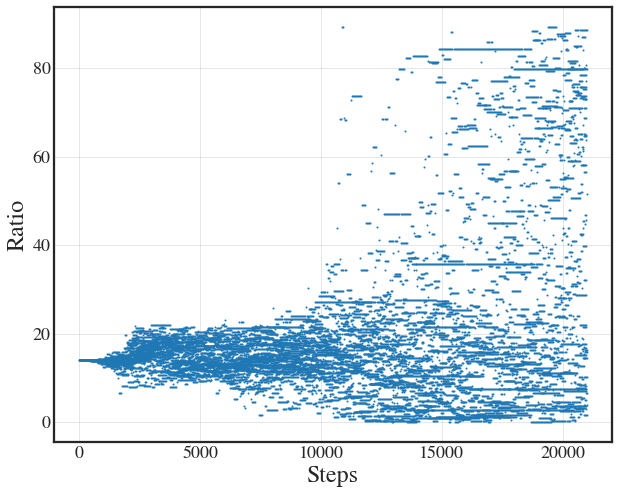

In [98]:
flat2 = res4.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat2['theta_inc'])), flat2['theta_inc'], s=1, alpha=1 ) 

#plt.plot( flat2['ratio_vel'][0::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][1::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][2::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 

plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')#, plt.xlim(0, 200000)
#plt.ylim(0.99, 1.01)
#plt.xscale('log'), plt.xlim(1000,len(flat['vphot']))
#plt.ylim(1)
#plt.savefig('Pictures/Assym_transient_epoch2_090.png', dpi=300)

print(np.mean(flat2['ratio_vel']), np.std(flat2['ratio_vel']))
print(np.median(flat2['ratio_vel']), np.percentile(flat2['ratio_vel'], 16), np.percentile(flat2['ratio_vel'], 84))

1.01037205163148 0.030752486775160046
1.0004133833583695 0.9940526252289077 1.016837600436107


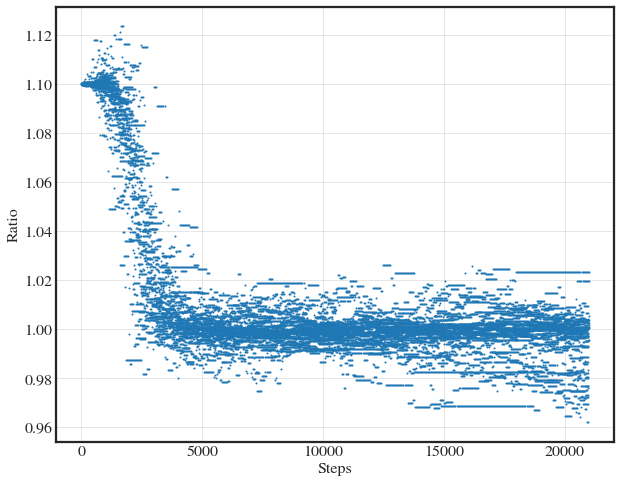

In [100]:
flat2 = res4.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat2['theta_inc'])), flat2['ratio_vel'], s=1, alpha=1 ) 

#plt.plot( flat2['ratio_vel'][0::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][1::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][2::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 

plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')#, plt.xlim(0, 200000)
#plt.ylim(0.99, 1.01)
#plt.xscale('log'), plt.xlim(1000,len(flat['vphot']))
#plt.ylim(1)
#plt.savefig('Pictures/Assym_transient_epoch2_090.png', dpi=300)

print(np.mean(flat2['ratio_vel']), np.std(flat2['ratio_vel']))
print(np.median(flat2['ratio_vel']), np.percentile(flat2['ratio_vel'], 16), np.percentile(flat2['ratio_vel'], 84))

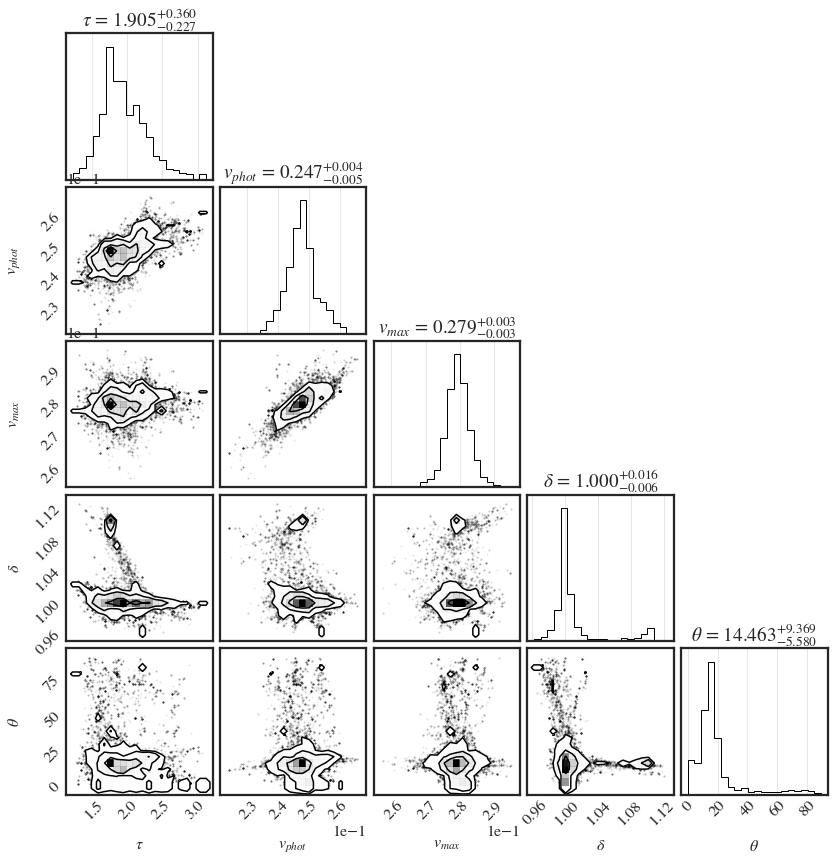

In [99]:
reset_plt(16,16)
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
#reset_plt(16, 14)
corner.corner( np.array([flat['tau'], flat['vphot'], flat['vmax'], flat['ratio_vel'], flat['theta_inc']]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

In [101]:
#with open("./Data/OB2/OB2_fit_ratio_vel_110_perfect_42x500.pkl", 'wb') as outfile:
#    pickle.dump(res4, outfile) 

In [74]:
res3.acceptance_fraction

array([0.0825 , 0.06875, 0.04875, 0.0525 , 0.08125, 0.0675 , 0.04875,
       0.07   , 0.08875, 0.0475 , 0.07875, 0.0825 , 0.05   , 0.0575 ])

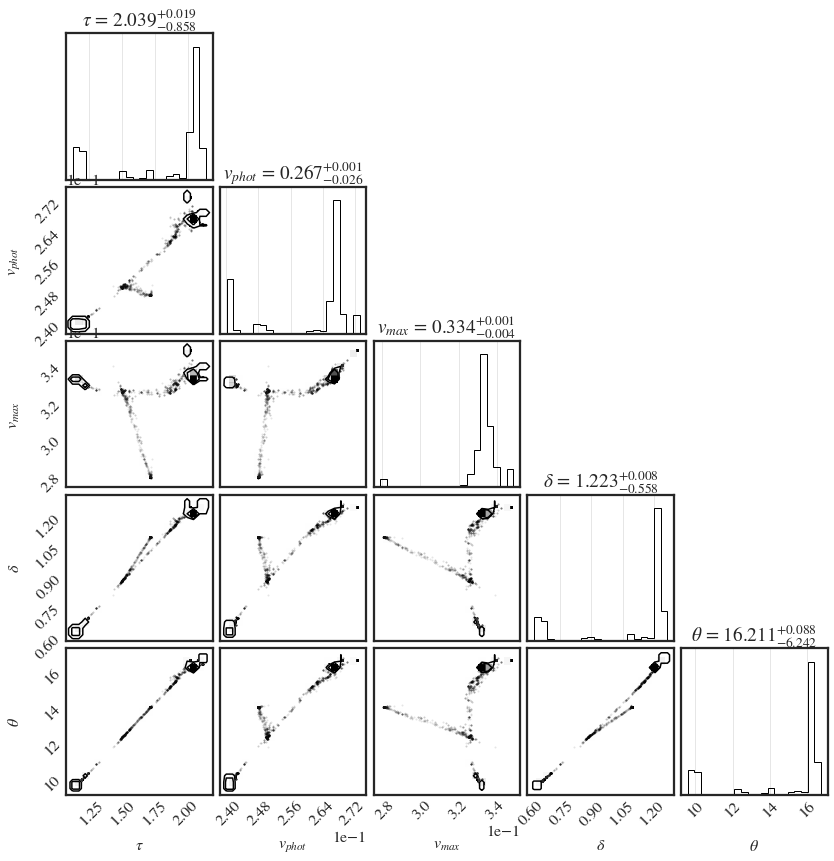

In [76]:
reset_plt(16,16)
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
#reset_plt(16, 14)
corner.corner( np.array([flat['tau'], flat['vphot'], flat['vmax'], flat['ratio_vel'], flat['theta_inc']]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

1.0932834864141383 0.228423193824546
1.222686070321522 0.6650507539152581 1.2303764477253107


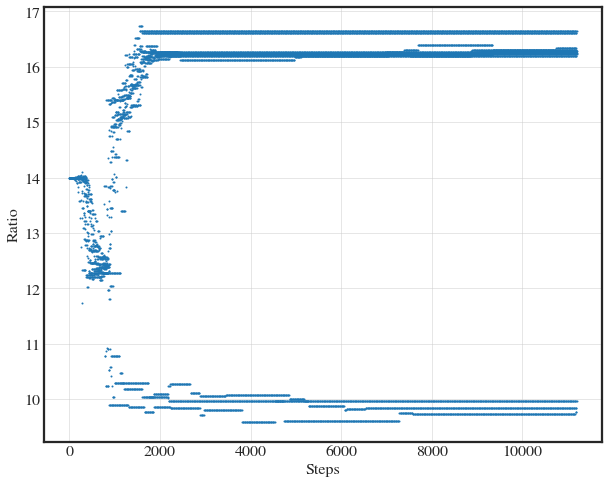

In [75]:
flat2 = res3.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat2['theta_inc'])), flat2['theta_inc'], s=1, alpha=1 ) 

#plt.plot( flat2['ratio_vel'][0::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][1::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][2::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 

plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')#, plt.xlim(0, 200000)
#plt.ylim(0.99, 1.01)
#plt.xscale('log'), plt.xlim(1000,len(flat['vphot']))
#plt.ylim(1)
#plt.savefig('Pictures/Assym_transient_epoch2_090.png', dpi=300)

print(np.mean(flat2['ratio_vel']), np.std(flat2['ratio_vel']))
print(np.median(flat2['ratio_vel']), np.percentile(flat2['ratio_vel'], 16), np.percentile(flat2['ratio_vel'], 84))

1.0932834864141383 0.228423193824546
1.222686070321522 0.6650507539152581 1.2303764477253107


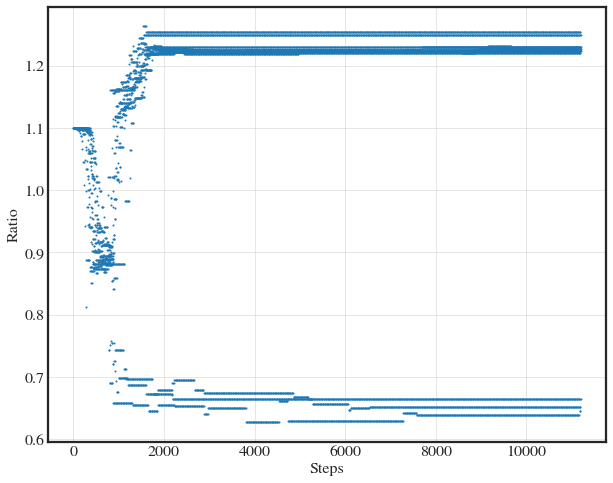

In [77]:
flat2 = res3.flatchain

plt.figure(figsize=(10,8))
plt.scatter( np.arange(len(flat2['theta_inc'])), flat2['ratio_vel'], s=1, alpha=1 ) 

#plt.plot( flat2['ratio_vel'][0::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][1::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 
#plt.plot( flat2['ratio_vel'][2::nwalkers], alpha=0.5, color='red')#, s=0.3, alpha=0.1 ) 

plt.ylabel('Ratio'), plt.xlabel('Steps')
plt.ticklabel_format(axis='x', style='plain')#, plt.xlim(0, 200000)
#plt.ylim(0.99, 1.01)
#plt.xscale('log'), plt.xlim(1000,len(flat['vphot']))
#plt.ylim(1)
#plt.savefig('Pictures/Assym_transient_epoch2_090.png', dpi=300)

print(np.mean(flat2['ratio_vel']), np.std(flat2['ratio_vel']))
print(np.median(flat2['ratio_vel']), np.percentile(flat2['ratio_vel'], 16), np.percentile(flat2['ratio_vel'], 84))

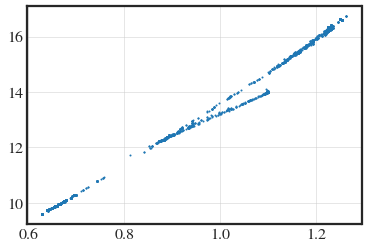

In [78]:
plt.scatter(flat2['ratio_vel'], flat2['theta_inc'], s=1)